# A tutorial for running a flood simulation

This tutorial is written as a Jupyter notebook and provides a step-by-step tutorial for setting up a flood model and plot its outputs. We will use the sample data included in the synxflow package. The notebook can be downloaded from [Github](https://github.com/pypims/pypims/blob/master/docs/source/Tutorials/flood.ipynb).

Authors: 
[Xilin Xia](https://www.birmingham.ac.uk/staff/profiles/civil/xia-xilin.aspx), 
[Xiaodong Ming](https://www.ncl.ac.uk/engineering/staff/profile/xiaodongming.html#background)

Date: 03/10/2023

## Explaining the data

The first step is to list which data is included in the sample.

In [1]:
from synxflow import IO
import os
from synxflow.IO.demo_functions import get_sample_data
dem_file, demo_data, data_path = get_sample_data() # get the path of sample data
os.listdir(data_path)

['rain_mask.gz', 'landcover.gz', 'DEM.gz', 'rain_source.csv']

As we can see from the list, there are 4 files in the folder. The three files ended with '.gz' are raster files for the DEM, rainfall mask and land cover types. These files are gzip compressions of ArcGIS ASCII format. We used compressed format to save some space, but pypims can also read original ArcGIS ASCII or GeoTIFF formats. The other file named 'rain_source.csv' is the time series of the rainfall intensity. We will now load these files and explain what they are used for in the simulation.

The first file we will look at is 'DEM.gz'. It defines the topography on which the flood simulation is running. In the simulation, each single valid pixel in the DEM is a cell within the computational domain. We can use the 'Raster' and 'mapshow' functions built in pypims to visualise them. As we can see from the figure, the DEM represents a catchment with a main river ending in the sea.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

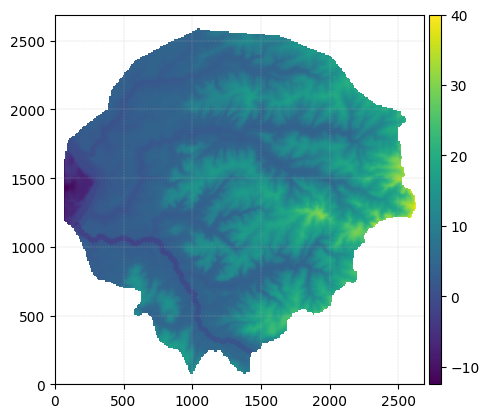

In [2]:
DEM = IO.Raster(os.path.join(data_path,'DEM.gz')) # load the file into a Raster object
DEM.mapshow() # plot the Raster object

The other file 'rain_mask' gives an index (0, 1, 2, ...) to every grid cell. These indices decide which column of the rainfall intensity time series will be used as the rainfall source term. As we can see from the figure, the domain has four different indices '0', '1', '2', '3'.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

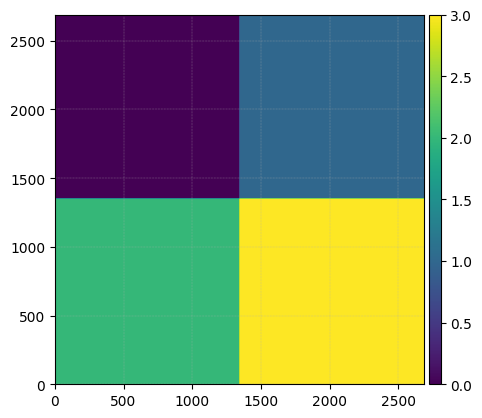

In [3]:
rain_mask = IO.Raster(os.path.join(data_path,'rain_mask.gz'))
rain_mask.mapshow()

We can use the pandas package to load 'rain_source.csv' and show its contents. The first column is the time stamps (in seconds). The other columns are the rainfall intensity values (in meter per second) for cells with rain mask indices starting from 0. For instance, the second column is for cells with index 0, the third column is for cells with index 1 and so on. 

In [4]:
import pandas as pd
rain_source = pd.read_csv(os.path.join(data_path,'rain_source.csv'), header = None)
rain_source.head()

,0,1,2,3,4
0,0,0,0.000014,0,0.000001
1,360,0,0.000014,0,0.000001
2,720,0,0.000014,0,0.000001
3,1080,0,0.000014,0,0.000001
4,1440,0,0.000014,0,0.000001


The file 'landcover.gz' gives difference indices to each grid cell to label their land cover types. In our case, there are two land cover types labelled by '0' and '1'. We can use it as a reference to define parameters that are spatially variable.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

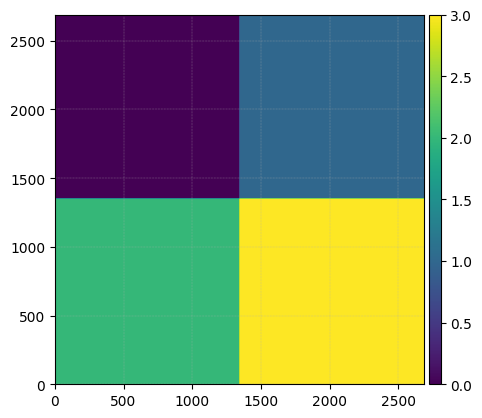

In [5]:
landcover = IO.Raster(os.path.join(data_path,'landcover.gz'))
landcover.mapshow()

## Generating the inputs and runing the simulation

We will now use the data we have just loaded to set up a flood model. In the first step, we need to initialise an InputModel object with the DEM. We also want to specify the directory where the simulation is run and the number of devices we want to use. In this example, we will only use a single GPU, but synxflow support multiple GPUs too.

In [6]:
ngpus = 1
case_folder = os.path.join(os.getcwd(), 'flood_case') # define a case folder in the current directory
case_input = IO.InputModel(DEM, num_of_sections=ngpus, case_folder=case_folder)

We can then put some water in the catchment by setting an initial depth. In our case, the initial water depth is 0 m across the catchment.

In [7]:
case_input.set_initial_condition('h0', 0.0)

We need to put some boundary conditions herein. We assume that there is a 100 m3/s dicharge from the upstream of the river, and depth at the downstream is fixed as 12.5 m. The locations of the boundaries can be defined by a few boxes that enclose the boundary sections. We simply need to define the coordinates of two opposite corners of the box, for instance, the upper left and bottom right coner points. 

In [8]:
import numpy as np
box_upstream = np.array([[1427, 195],  # bottom left
                         [1446, 243]]) # upper right
box_downstream = np.array([[58, 1645], # upper left
                           [72, 1170]]) # bottom right
discharge_values = np.array([[0, 100], # first column: time - s; second colum: discharge - m3/s
                            [3600,100]])

We then use a list of dicts to put things together.

In [9]:
bound_list = [
            {'polyPoints': box_upstream,
             'type': 'open',
             'hU': discharge_values},
            {'polyPoints': box_downstream,
             'type': 'open',
             'h': np.array([[0, 5],
                            [3600,5]])}] # we fix the downstream depth as 12.5 m

Now we can set up the boundary conditions and check whether they have been set up correctly.

Flow series on boundary 1 is converted to velocities
Theta = 135.00degree


(<Figure size 640x480 with 2 Axes>, <Axes: title={'center': 'Domain Map'}>)

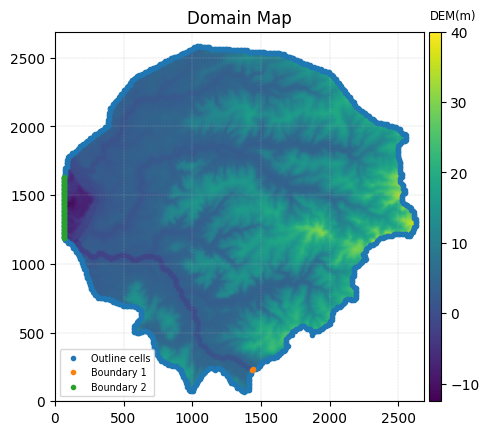

In [10]:
case_input.set_boundary_condition(boundary_list=bound_list)
case_input.domain_show() # show domain map

Great, the boundary conditions are set up correctly! We now need to setup the rainfall mask and rainfall time series.

In [11]:
rain_source_np = rain_source.to_numpy()
case_input.set_rainfall(rain_mask=rain_mask, rain_source=rain_source_np)

We also need to set up values for the Manning's n. We can use the landcover map to define a spatially variable Manning's n.

In [12]:
case_input.set_landcover(landcover)
case_input.set_grid_parameter(manning={'param_value': [0.035, 0.055],
                                        'land_value': [0, 1],
                                        'default_value':0.035})

We want to see the time histories of the depth at both the downstream and upstream of the main river, so we need to set up a gauging point in the model.

In [13]:
case_input.set_gauges_position(np.array([[560, 1030],
                                        [1140,330]]))

The final thing we want to set up is the runtime. We want to run the simulation for 2 hours, get the raster outpurs for every 15 minutes and backup the simulation for every half an hour.

In [14]:
case_input.set_runtime([0, 7200, 900, 1800])

'0-start, 7200-end, 900-output interval, 1800-backup interval'

We have now finished setting up the model. Let's see what the model summary tells us.

In [15]:
print(case_input)

---------------------- Model information ---------------------
case_folder : /bask/homes/x/xiaxz/synxflow/docs/source/Tutorials/flood_case
birthday : 2023-10-03 16:29
num_GPU : 1
run_time : [0, 7200, 900, 1800]
num_gauges : 2
---------------------- Grid information ----------------------
area : [4351200.0, 'm^2']
shape : (269, 269)
cellsize : [10.0, 'm']
num_cells : 43512
extent : {'left': 0.0, 'right': 2690.0, 'bottom': 0.0, 'top': 2690.0}
---------------------- Initial condition ---------------------
h0 : 0.0
hU0x : 0
hU0y : 0
---------------------- Boundary condition --------------------
num_boundary : 3
boundary_details : ['0. (outline) fall, h and hU fixed as zero, number of cells: 788', '1. open, hU given, number of cells: 2', '2. open, h given, number of cells: 46']
---------------------- Rainfall ------------------------------
num_source : 4
max : [50.0, 'mm/h']
sum : [12.38, 'mm']
average : [13.75, 'mm/h']
spatial_res : [924.0, 'm']
temporal_res : [360.0, 's']
----------------

All seems to be good. We can now write these inputs into files that the flood simulation engine reads.

In [16]:
case_input.write_input_files()

/bask/homes/x/xiaxz/synxflow/docs/source/Tutorials/flood_case/input/mesh/DEM.txt created
times_setup.dat created
device_setup.dat created
z created
h created
hU created
precipitation created
manning created
sewer_sink created
cumulative_depth created
hydraulic_conductivity created
capillary_head created
water_content_diff created
precipitation_mask created
precipitation_source_all.dat created
boundary condition files created
gauges_pos.dat created


Let's run the model now. It will show 'Simulation successfully finished' if the simulation finishes without an error.

In [17]:
from synxflow import flood
if ngpus > 1:
    flood.run_mgpus(case_folder)
else:
    flood.run(case_folder)

GPU 0 is choosen as the model device
Current time: 0s
Total time: 7200s
Output time interval: 900s
Backup interval: 1800s
Read in mesh successfully
Read in field successfully
0
0.005
0.16660736144148014
1.4452849108865498
2.0573213512181767
2.637117086928493
3.169992218500065
3.6662755636537603
4.1451196762129126
4.609860604185718
5.071063611276978
5.5200074028202275
5.957642573858299
6.385683451026194
6.802888216760794
7.211287796666992
7.6101233152863905
8.00074049327688
Writing backup files
8.385143955292454
8.764939258942842
9.141437798653788
9.516669813034376
9.89280308405864
10.26806458667747
10.643450171447569
11.019904509745045
11.398088750598406
11.778444503946973
12.161334514014948
12.54711222318303
12.936093289534982
13.327289429761333
13.718235919238193
14.111333391211286
14.507920735087984
14.908878156028374
15.3126031645069
15.719196220253144
16.12917329105138
16.542797438458475
16.960212426110903
17.38149918089589
17.806695467099445
18.235798605432027
18.66876751657851
1

## Plotting the results

After the simulation finishes, we can plot the depth at the gauge point and the maximum inundation depth over the domain. To do this, we need to create an OutputHipims object first.

In [18]:
case_output = IO.OutputModel(input_obj = case_input)

Then we can read the depth from the outputs.

In [19]:
gauges_pos, times, values = case_output.read_gauges_file(file_tag = 'h')

After reading the output into numpy arrays, we can use matplotlib package to plot the depths at the gauge points.

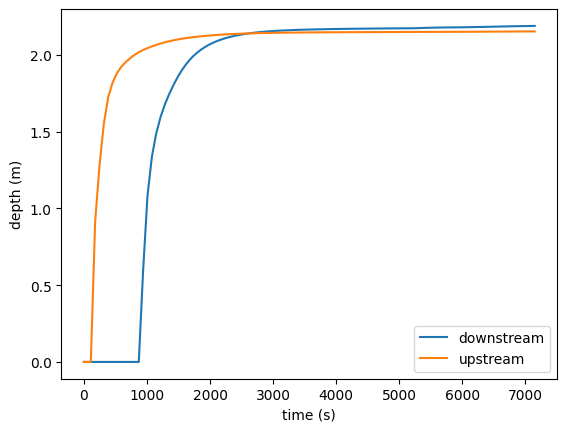

In [20]:
import matplotlib.pyplot as plt
lines = plt.plot(times, values)
plt.xlabel('time (s)')
plt.ylabel('depth (m)')
plt.legend(lines[:2],['downstream','upstream'])
plt.show()

We can also use pypims to read the raster outpus and use mapshow to show the results.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

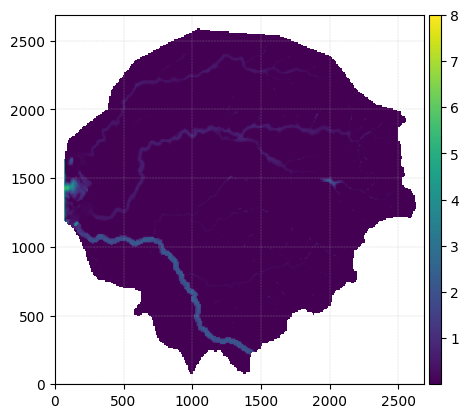

In [21]:
max_depth = case_output.read_grid_file(file_tag='h_max_7200')
max_depth.mapshow()

Pypims only provides some basic functions for visualising the outputs. If you need to plot something more beautiful for your reports or papers, the matplotlib package is a good place to start with. 

Hope you have enjoyed reading this tutorial. Please dive into the [API documentation](https://pypims.readthedocs.io/en/latest/Modules/index.html) for more advanced usage of pypims.